# Important libraries

In [1]:
import numpy as np
import cv2
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab

%matplotlib inline
pylab.rcParams["figure.figsize"] = (8.,8.)

### Function for stacking images

In [2]:
def stackImages(scale,imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape [:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None,scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        ver = hor
    return ver

In [3]:
img1 = cv2.imread("test1.jpg")
img2 = cv2.imread("test2.jpg")
imgstack = stackImages(0.4,([img1],
                            [img2]))
imgstack = cv2.cvtColor(imgstack,cv2.COLOR_BGR2RGB)


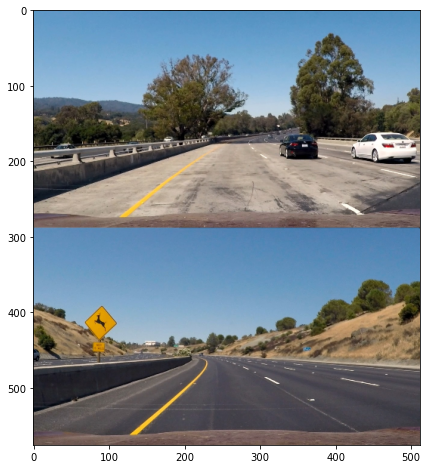

In [4]:
plt.imshow(imgstack) 

## Load yolo weights and config

In [5]:
weights_path = os.path.join("yolo", "yolov3.weights")
config_path = os.path.join("yolo", "yolov3.cfg")


In [6]:
#load the neural net in cv2
net= cv2.dnn.readNetFromDarknet(config_path, weights_path)

#get Layers Names
names= net.getLayerNames()

In [7]:
names

('conv_0',
 'bn_0',
 'leaky_1',
 'conv_1',
 'bn_1',
 'leaky_2',
 'conv_2',
 'bn_2',
 'leaky_3',
 'conv_3',
 'bn_3',
 'leaky_4',
 'shortcut_4',
 'conv_5',
 'bn_5',
 'leaky_6',
 'conv_6',
 'bn_6',
 'leaky_7',
 'conv_7',
 'bn_7',
 'leaky_8',
 'shortcut_8',
 'conv_9',
 'bn_9',
 'leaky_10',
 'conv_10',
 'bn_10',
 'leaky_11',
 'shortcut_11',
 'conv_12',
 'bn_12',
 'leaky_13',
 'conv_13',
 'bn_13',
 'leaky_14',
 'conv_14',
 'bn_14',
 'leaky_15',
 'shortcut_15',
 'conv_16',
 'bn_16',
 'leaky_17',
 'conv_17',
 'bn_17',
 'leaky_18',
 'shortcut_18',
 'conv_19',
 'bn_19',
 'leaky_20',
 'conv_20',
 'bn_20',
 'leaky_21',
 'shortcut_21',
 'conv_22',
 'bn_22',
 'leaky_23',
 'conv_23',
 'bn_23',
 'leaky_24',
 'shortcut_24',
 'conv_25',
 'bn_25',
 'leaky_26',
 'conv_26',
 'bn_26',
 'leaky_27',
 'shortcut_27',
 'conv_28',
 'bn_28',
 'leaky_29',
 'conv_29',
 'bn_29',
 'leaky_30',
 'shortcut_30',
 'conv_31',
 'bn_31',
 'leaky_32',
 'conv_32',
 'bn_32',
 'leaky_33',
 'shortcut_33',
 'conv_34',
 'bn_34',
 'l

## Our Test Image

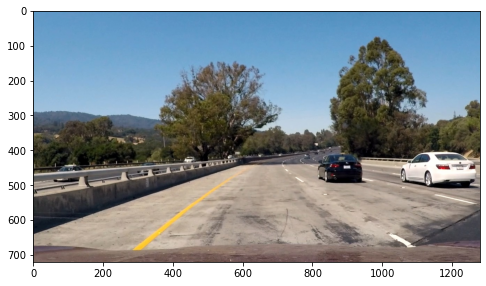

In [16]:
img = cv2.imread("test1.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)

## Object Detection and highlighting Function

In [12]:

def framePipeline(img):
    (H, W)= img.shape[:2]
    layers_names= [names[i - 1] for i in net.getUnconnectedOutLayers()]

    #run the inference on the test image
    blob= cv2.dnn.blobFromImage(img, 1/255.0, (416,416), crop= False, swapRB= False)
    net.setInput(blob)

    layers_output= net.forward(layers_names)

    boxes= []
    confidences= []
    classIDs= []

    for output in layers_output:
        for detection in output:
            scores= detection[5:]
            classID=np.argmax(scores)
            confidence= scores[classID]

            if(confidence > 0.85):
                box= detection[:4] * np.array([W, H, W, H])
                bx, by, bw, bh = box.astype("int")

                x= int(bx - (bw / 2))
                y= int(by - (bh / 2))

                boxes.append([x, y, int(bw), int(bh)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs= cv2.dnn.NMSBoxes(boxes, confidences, 0.8, 0.8)

    #read the labels file
    labels= open("yolo/coco.names").read().strip().split("\n")

    #plot the bounding boxes in the image
    if len(idxs) > 0:
        for i in idxs.flatten():
            (x,y)= [boxes[i][0], boxes[i][1]]
            (w,h)= [boxes[i][2], boxes[i][3]]

            cv2.rectangle(img, (x,y), (x+w, y+h), (0,164,164), 2)
            cv2.putText(img, "{}: {}".format(labels[classIDs[i]], confidences[i]), (x, y-5), cv2.FONT_ITALIC, 0.5, (0,164,164), 2)


    outputImg=img
    imgStack = stackImages(0.4, ([img1],
                                 [outputImg]))
    return imgStack





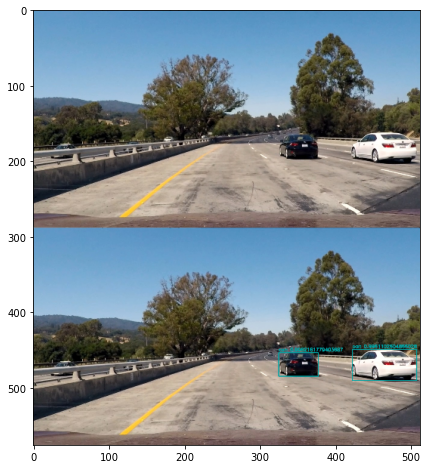

In [15]:
img = cv2.imread("test1.jpg")
img1 = img
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img = framePipeline(img)

plt.imshow(img)

## Choose input mode 

In [9]:
path= sys.argv[2]

if sys.argv[1] == "img":

    img = cv2.imread(path)
    img1 = cv2.imread(path)
    img, img1 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR),cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    plt.imshow(framePipeline(img))
    plt.show()


elif sys.argv[1] == "vid":
    video = cv2.VideoCapture(path)
    frameWidth = int(video.get(3))
    frameHeight = int(video.get(4))

    while video.isOpened():
        ret1, img1 = video.read()
        ret, frame = video.read()

        if ret == True:
            #img1= frame
            frame = framePipeline(frame)
            cv2.imshow('Frame', frame)
            if cv2.waitKey(1) & 0xFF == ord('s'): #press s to stop the running video
                break
        else:
            break
    video.release()
    cv2.destroyAllWindows()
